#### Homework Solution for Week 4

In [1]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
# !unzip bank+marketing.zip 
# !unzip bank.zip

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
raw_data = pd.read_csv("/app/new/splatter-image/DTC/Machine Learning Zoomcamp/week3/bank-full.csv", sep=";")
raw_data.columns = raw_data.columns.str.lower().str.replace(' ', '_')
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
used_columns = ["age", "job", "marital", "education", "balance", 
                "housing", "contact", "day", "month", "duration", 
                "campaign", "pdays", "previous", "poutcome", "y"]
sample_data = raw_data.loc[:, used_columns]
sample_data.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
categorical_columns = sample_data.columns[sample_data.dtypes == "object"].values[:-1]
numerical_columns = sample_data.columns[sample_data.dtypes != "object"].values
categorical_columns, numerical_columns

(array(['job', 'marital', 'education', 'housing', 'contact', 'month',
        'poutcome'], dtype=object),
 array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
        'previous'], dtype=object))

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score

X = sample_data.iloc[:, :-1]
y = sample_data["y"].map({'yes': 1.0, 'no': 0.0})

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

X_full_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_full_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

##### Question 1: ROC AUC feature importance

In [7]:
numerical_importance = [roc_auc_score(y_true=y_train, y_score=X_train.loc[:, col]) for col in numerical_columns]
numerical_col_importance = list(zip(numerical_columns, numerical_importance))
print(numerical_col_importance)
for col, imp in numerical_col_importance:
    if imp < 0.5:
        print(f"Changing sign for [{col}] column")
        X_train.loc[:, col] *= -1
        X_val.loc[:, col] *= -1
        X_test.loc[:, col] *= -1

[('age', 0.48781428247265596), ('balance', 0.5888313805382317), ('day', 0.474042117616092), ('duration', 0.8147002759670778), ('campaign', 0.42854569843178414), ('pdays', 0.5901276247352144), ('previous', 0.5985653242764153)]
Changing sign for [age] column
Changing sign for [day] column
Changing sign for [campaign] column


In [8]:
print(f"[{numerical_columns[np.argmax(numerical_importance)]}] column has the highest AUC")

[duration] column has the highest AUC


##### Question 2: Training the model

In [9]:
dict_transformer = DictVectorizer(sparse=False)
dict_transformer.fit(X_train.to_dict(orient="records"))

x_train = dict_transformer.transform(X_train.to_dict(orient="records"))
x_val = dict_transformer.transform(X_val.to_dict(orient="records"))
x_test = dict_transformer.transform(X_test.to_dict(orient="records"))

dict_transformer.get_feature_names_out()

array(['age', 'balance', 'campaign', 'contact=cellular',
       'contact=telephone', 'contact=unknown', 'day', 'duration',
       'education=primary', 'education=secondary', 'education=tertiary',
       'education=unknown', 'housing=no', 'housing=yes', 'job=admin.',
       'job=blue-collar', 'job=entrepreneur', 'job=housemaid',
       'job=management', 'job=retired', 'job=self-employed',
       'job=services', 'job=student', 'job=technician', 'job=unemployed',
       'job=unknown', 'marital=divorced', 'marital=married',
       'marital=single', 'month=apr', 'month=aug', 'month=dec',
       'month=feb', 'month=jan', 'month=jul', 'month=jun', 'month=mar',
       'month=may', 'month=nov', 'month=oct', 'month=sep', 'pdays',
       'poutcome=failure', 'poutcome=other', 'poutcome=success',
       'poutcome=unknown', 'previous'], dtype=object)

In [10]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)
validation_score = roc_auc_score(y_true=y_val, y_score=model.predict_proba(x_val)[:, 1])
print(f"The AUC of this model on the validation dataset = {np.round(validation_score, decimals=3)}")


The AUC of this model on the validation dataset = 0.9


##### Question 3: Precision and Recall

At 0.27 threshold point precision and recall curves intersect


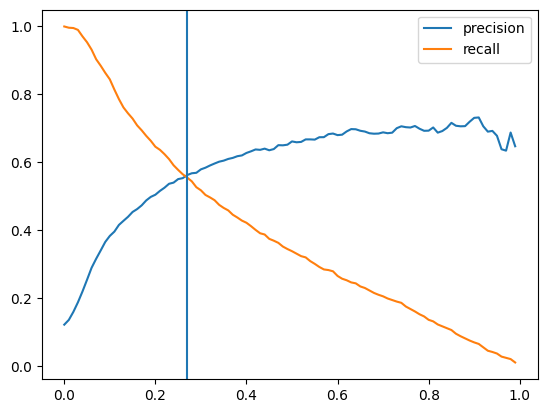

In [11]:
thresholds = np.arange(0.0, 1.0, 0.01)
y_score_validation = model.predict_proba(x_val)[:, 1]
thrs = lambda th: np.array(y_score_validation >= th, dtype=float)

precision = np.array([precision_score(y_val, thrs(th)) for th in thresholds])
recall = np.array([recall_score(y_val, thrs(th)) for th in thresholds])
intersection_point = thresholds[np.argmin(np.abs(precision-recall))]
print(f"At {intersection_point} threshold point precision and recall curves intersect")

plt.plot(thresholds, precision, label="precision")
plt.plot(thresholds, recall, label="recall")
plt.axvline(x=intersection_point)
plt.legend()

##### Question 4: F1 score

At 0.23 threshold point F1 is maximal


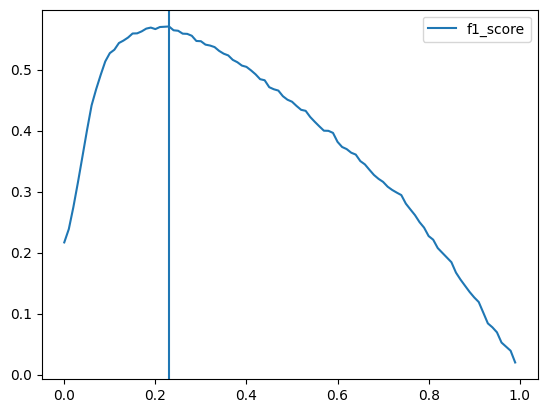

In [12]:
thresholds = np.arange(0.0, 1.0, 0.01)
y_score_validation = model.predict_proba(x_val)[:, 1]
thrs = lambda th: np.array(y_score_validation >= th, dtype=float)

precision = np.array([precision_score(y_val, thrs(th)) for th in thresholds])
recall = np.array([recall_score(y_val, thrs(th)) for th in thresholds])
f1_score = 2*precision*recall/(precision + recall)

max_point = thresholds[np.argmax(f1_score)]
print(f"At {max_point} threshold point F1 is maximal")

plt.plot(thresholds, f1_score, label="f1_score")
plt.axvline(x=max_point)
plt.legend()

##### Question 5: 5-Fold CV

In [13]:
from sklearn.model_selection import KFold

iteration_kf = 5
auc_score_history = []

kFoldTrain = KFold(n_splits=iteration_kf, shuffle=True, random_state=1)

for idx, (train_indx, val_indx) in enumerate(kFoldTrain.split(X_full_train)):
    x_fold_train = X_full_train.iloc[train_indx, :]
    y_fold_train = y_full_train[train_indx]
    
    x_fold_val = X_full_train.iloc[val_indx, :]
    y_fold_val = y_full_train[val_indx]
    
    dict_transformer = DictVectorizer(sparse=False)
    dict_transformer.fit(x_fold_train.to_dict(orient="records"))
    
    x_fold_train = dict_transformer.transform(x_fold_train.to_dict(orient="records"))
    x_fold_val = dict_transformer.transform(x_fold_val.to_dict(orient="records"))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(x_fold_train, y_fold_train)
    
    validation_score = roc_auc_score(y_true=y_fold_val, y_score=model.predict_proba(x_fold_val)[:, 1])
    print(f"The Validation AUC Score for {idx}th fold = {np.round(validation_score, decimals=3)}")
    
    auc_score_history.append(validation_score)
    
print(f"\nMean AUC = {np.mean(auc_score_history)} | Std AUC = {np.round(np.std(auc_score_history), decimals=3)}\n")

The Validation AUC Score for 0th fold = 0.899
The Validation AUC Score for 1th fold = 0.899
The Validation AUC Score for 2th fold = 0.911
The Validation AUC Score for 3th fold = 0.908
The Validation AUC Score for 4th fold = 0.912

Mean AUC = 0.9060177360822426 | Std AUC = 0.006



##### Question 6: Hyperparameter Tuning

In [14]:
iteration_kf = 5
auc_score_history = dict()

for lambda_reg in [0.000001, 0.001, 1]:
    
    kFoldTrain = KFold(n_splits=iteration_kf, shuffle=True, random_state=1)

    for idx, (train_indx, val_indx) in enumerate(kFoldTrain.split(X_full_train)):
        x_fold_train = X_full_train.iloc[train_indx, :]
        y_fold_train = y_full_train[train_indx]
        
        x_fold_val = X_full_train.iloc[val_indx, :]
        y_fold_val = y_full_train[val_indx]
        
        dict_transformer = DictVectorizer(sparse=False)
        dict_transformer.fit(x_fold_train.to_dict(orient="records"))
        
        x_fold_train = dict_transformer.transform(x_fold_train.to_dict(orient="records"))
        x_fold_val = dict_transformer.transform(x_fold_val.to_dict(orient="records"))
        
        model = LogisticRegression(solver='liblinear', C=lambda_reg, max_iter=1000)
        model.fit(x_fold_train, y_fold_train)
        
        validation_score = roc_auc_score(y_true=y_fold_val, y_score=model.predict_proba(x_fold_val)[:, 1])
        
        
        if lambda_reg in auc_score_history.keys():
            auc_score_history[lambda_reg].append(validation_score)
        else:
            auc_score_history[lambda_reg] = [validation_score]
        
    print(f"\nC=[{lambda_reg}] Mean AUC = {np.mean(auc_score_history[lambda_reg])} | Std AUC = {np.round(np.std(auc_score_history[lambda_reg]), decimals=3)}\n")

#### End of Task! Looking forward to solving the next assignment